In [1]:
import matplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from helpers import download_dataset

In [964]:
URL = 'https://www.kaggle.com/crawford/weekly-sales-transactions'
DEST = './data'
download_dataset(URL, './data')
df = pd.read_csv('./data/%s' % 'Sales_Transactions_Dataset_Weekly.csv', encoding='utf-8').dropna()

# Make Column Names for Weeks and Normalized

In [965]:
week_cols = ['W%s' % i for i in range(52)]
norm_cols = ['Normalized %s' % i for i in range(52)]

week_df = df[week_cols]
norm_df = df[norm_cols]

# Get Min, Max, Median across Columns

In [963]:
minimum = pd.concat([df.Product_Code, week_df.min(axis=1)], keys=['Product_Code', 'Min'], axis=1)
maximum = pd.concat([df.Product_Code, week_df.max(axis=1)], keys=['Product_Code', 'Max'], axis=1)
median = pd.concat([df.Product_Code, week_df.median(axis=1)], keys=['Product_Code', 'Median'], axis=1)

# Visualization
Visualizing histogram distribution of min, max, and median

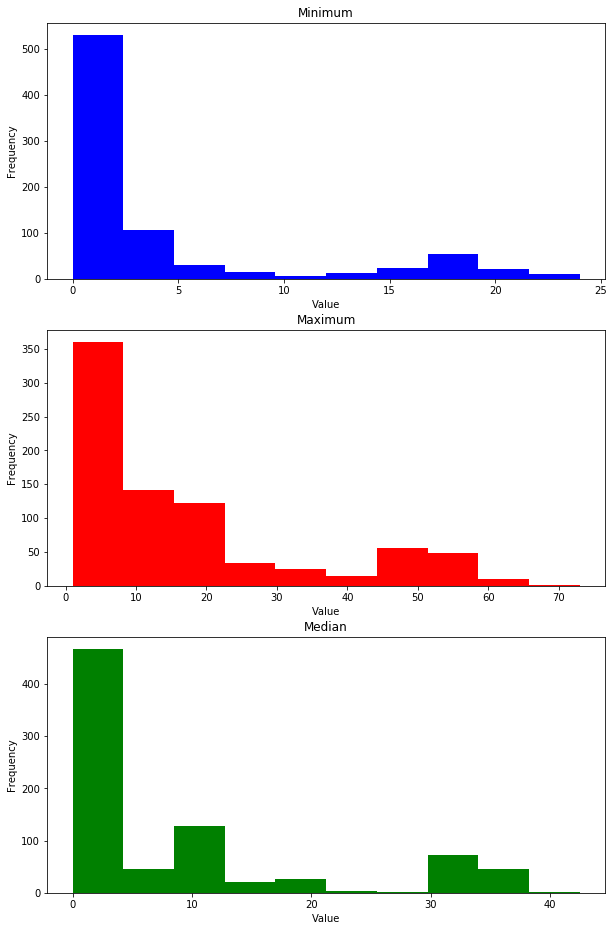

In [952]:
plt.figure(figsize=(10,16))
plot = {'Minimum': minimum.Min, 'Maximum': maximum.Max, 'Median': median.Median}
colour = ['blue', 'red', 'green']

for i in range(1, 4):
    plt.subplot(3, 1, i)
    title = list(plot.keys())[i-1]
    plt.title(title)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.hist(plot[title], bins=10, color=colour[i-1])

# Best Performing Product
Identify this with the total sales over the year

In [953]:
best_performing_product =  df.loc[df[week_cols].sum(axis=1).idxmax(), 'Product_Code']
best_performing_sales = df[week_cols].sum(axis=1).max()
'Best Performing Product: {} with total sales {} txn'.format(best_performing_product, best_performing_sales)

'Best Performing Product: P409 with total sales 2220 txn'

# Most Promising/ Emerging Product
1. For a product to be promising, it has to have a high momentum in its sales
2. Here I divide the sales momentum into last quarter, half and whole year
3. I compute the average gradient of sales

In [954]:
def get_gradient(num):
    sales_sum = np.sum(week_df.iloc[:,-num:].values, axis=1)
    gradient = sales_sum/ num
    return gradient

def get_sales(num):
    gradient = get_gradient(num)
    gradient_max = gradient.max()
    idx = np.where(gradient==gradient_max)[0][0]
    
    return {'Product_Code': df.Product_Code.iloc[idx],
            'Sales_Gradient':  gradient_max}


quarter = int(week_df.shape[1]*0.25)
half = int(week_df.shape[1]*0.5)
full = int(week_df.shape[1])

most_promising_quarter = get_sales(quarter)
most_promising_half = get_sales(half)
most_promising_full = get_sales(full)

In [955]:
print(
    
'\n\tMost Promising in last quarter: {} with sales {:.3f} txn/week.\n\n'.format(
                                                            most_promising_quarter['Product_Code'],
                                                            most_promising_quarter['Sales_Gradient']),
    
'\tMost Promising in last half: {} with sales {:.3f} txn/week.\n\n'.format(
                                                            most_promising_half['Product_Code'],
                                                            most_promising_half['Sales_Gradient']),
    
'\tMost Promising in last year: {} with sales {:.3f} txn/week.\n\n'.format(
                                                            most_promising_full['Product_Code'],
                                                            most_promising_full['Sales_Gradient'])

)


	Most Promising in last quarter: P409 with sales 44.846 txn/week.

 	Most Promising in last half: P409 with sales 38.346 txn/week.

 	Most Promising in last year: P409 with sales 42.692 txn/week.




# Visualization

# Top 5 Worst Performing Products Biweekly

In [956]:
# group all biweekly columns together
biweekly = (np.arange(0, week_df.shape[1], 1))//2
# sum their values across the columns
worst_performing_sum = week_df.groupby(
                            biweekly,
                            axis=1
                            ).sum(axis=1)

# Initialize data dictionary and odd number in week names
data = {}
weeks, = np.where(np.arange(0, week_df.shape[1], 1)%2==1)

# make dict for top 5 worst performing product code and sales number biweekly
for i, week in zip(worst_performing_sum, weeks):
    row = {}
    number = list(worst_performing_sum[i].nsmallest(5).values)
    product = df.Product_Code[list(worst_performing_sum[i].nsmallest(5).index)].tolist()
    for k, v in zip(product, number):
        row[k] = v
    data[week_df.columns[week]] = row

for key, value in data.items():
    print('Product {}: {}'.format(key, ', '.join(value) if value else ''))

Product W1: P212, P213, P214, P215, P216
Product W3: P212, P213, P214, P215, P216
Product W5: P215, P216, P217, P218, P219
Product W7: P213, P214, P215, P216, P217
Product W9: P212, P213, P215, P216, P217
Product W11: P212, P214, P215, P216, P217
Product W13: P212, P213, P214, P215, P216
Product W15: P212, P213, P214, P215, P216
Product W17: P212, P214, P215, P216, P217
Product W19: P212, P213, P215, P217, P218
Product W21: P213, P214, P215, P216, P217
Product W23: P212, P213, P214, P216, P217
Product W25: P213, P215, P216, P217, P218
Product W27: P212, P213, P215, P217, P218
Product W29: P212, P213, P214, P215, P216
Product W31: P213, P214, P215, P217, P218
Product W33: P214, P215, P216, P218, P221
Product W35: P215, P216, P217, P218, P221
Product W37: P213, P215, P217, P218, P222
Product W39: P213, P215, P217, P221, P222
Product W41: P214, P215, P217, P218, P219
Product W43: P214, P215, P216, P217, P218
Product W45: P212, P213, P214, P215, P218
Product W47: P213, P215, P216, P218, P2

# Outliers Detection
1. The data we have are off different Product_Code
2. Product_Code is not related to each other even with different index
3. Hence, outliers first calculated are according to their Product_Code
4. With 811 Product_Code, we will have 811 sets of outliers
5. Technique used: **`Interquartile range/ boxplot`**

In [957]:
outliers = {}
for index, value in week_df.iterrows():
    row = []
    # get iqr range
    iqr_range = iqr(value, rng=(25, 75), interpolation='midpoint')
    # get lower threshold
    minimum = np.percentile(value, 25) - iqr_range*1.5
    # get upper threshold
    maximum = np.percentile(value, 75) + iqr_range*1.5
    # retrieve outcomes in between threshold
    outcome = value[value.where(np.logical_and(value >= minimum, value <= maximum)).isnull()].keys().tolist()
    outliers[df.Product_Code.iloc[index]] = outcome

# Print outcomes
for key, value in outliers.items():
    print('Product {}: {}'.format(key, ', '.join(value) if value else ''))

Product P1: W7
Product P2: 
Product P3: 
Product P4: W35
Product P5: 
Product P6: W18, W33, W50
Product P7: 
Product P8: W12, W36
Product P9: 
Product P10: 
Product P11: W51
Product P12: W38
Product P13: W6, W29, W47
Product P14: W14
Product P15: 
Product P16: 
Product P17: 
Product P18: 
Product P19: W16, W40
Product P20: W1, W6, W34, W46, W47
Product P21: 
Product P22: W11
Product P23: W24
Product P24: W51
Product P25: W18
Product P26: W21, W51
Product P27: 
Product P28: 
Product P29: W17
Product P30: 
Product P31: W1
Product P32: 
Product P33: 
Product P34: W3
Product P35: 
Product P36: W12
Product P37: W19
Product P38: W4
Product P39: 
Product P40: 
Product P41: 
Product P42: 
Product P43: 
Product P44: 
Product P45: W12
Product P46: 
Product P47: W7
Product P48: 
Product P49: 
Product P50: 
Product P51: W12, W25, W51
Product P52: 
Product P53: 
Product P54: 
Product P55: 
Product P56: 
Product P57: 
Product P58: 
Product P59: 
Product P60: 
Product P61: 
Product P62: 
Product P63:

# Outliers Aggregation
Lets try grouping the **`top 3`** week outliers among all products

In [958]:
from collections import Counter
grouped_outliers = []

for key in outliers.keys():
    grouped_outliers.extend(outliers[key])

'Top 3 week outliers: {}'.format(', '.join(list(dict(Counter(grouped_outliers).most_common(3)).keys())))

'Top 3 week outliers: W51, W25, W24'

# Original Codes

In [966]:
def get_outliers(sales_data):
    print('Outliers by week: \n')
    sales_np_array = np.array(sales_data.loc[:, sales_data.columns[1:53]])
    
    for row in sales_np_array:
        mean = np.mean(row)
        std = np.std(row)
        scores = [(i-mean) / std for i in row]
        index_data = np.array(np.where(np.abs(scores) > 3)).tolist()
        print(sales_data.columns[[i for index in index_data for i in index]])

# Refactoring Codes
1. First thing I notice is the code provided uses **`z-score`** to find outliers.
2. Therefore, I will optimize the code using **`z-score`** technique and also for each Product_Code

In [960]:
# Since there are normalized columns in the dataset, I will proceed to not use them
def standardize(array):
    return np.divide(array - np.mean(array), np.std(array))

def get_z_score(array):
    return np.abs(standardize(array))
    
# refactored
def refactor(df):
    print('Outliers by week: \n')
    sales = df.iloc[:, 1:53]
    scores = get_z_score(sales.values)
    
    for i in range(scores.shape[0]):
        index = np.where(scores[i] > 3)[0]
        weeks = sales.columns[index].tolist()
        print('Product {}: {}'.format(df.Product_Code.iloc[i], ', '.join([str(i) for i in weeks])))

# Original Codes
Run ***original codes*** and retreive its completion time

In [961]:
print('Beginning of orginal codes!\n')
current_time = datetime.now()
outcome = get_outliers(df)
print('\nCalculation took time: {}'
      .format(datetime.now() - current_time))

Beginning of orginal codes!

Outliers by week: 

Index(['W6'], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index(['W34'], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index(['W13'], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index(['W16'], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index(['W11'], dtype='

Index(['W48', 'W50'], dtype='object')
Index(['W3', 'W12'], dtype='object')
Index(['W21', 'W41'], dtype='object')
Index(['W24', 'W39'], dtype='object')
Index(['W48', 'W50'], dtype='object')
Index(['W17', 'W21', 'W43'], dtype='object')
Index(['W5'], dtype='object')
Index(['W10'], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index(['W50'], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index(['W2'], dtype='object')
Index(['W21'], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index(['W24'], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index(['W22'], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index

Index(['W45'], dtype='object')
Index(['W48'], dtype='object')
Index(['W23'], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index(['W50'], dtype='object')
Index(['W50'], dtype='object')
Index(['W46'], dtype='object')
Index(['W23'], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index(['W26', 'W43'], dtype='object')
Index(['W26'], dtype='object')
Index(['W49'], dtype='object')
Index(['W24'], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index(['W50'], dtype='object')
Index(['W44'], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index(['W22'], dtype='object')
Index([], dtype='object')
Index(['W22'], dtype='object')
Index(['W50'], dtype='object')
Index(['W49'], dtype='object')
Index(['W27', 'W35'], dtype='object')
Index(['W24'], dtype='object')
Index([

# Refactored Codes
Run ***refactored codes*** and retreive its completion time

In [962]:
print('Beginning of refactored codes!\n')
current_time = datetime.now()
outcome = refactor(df)
print('\nCalculation took time: {}'
      .format(datetime.now() - current_time))

Beginning of refactored codes!

Outliers by week: 

Product P1: 
Product P2: 
Product P3: 
Product P4: 
Product P5: 
Product P6: 
Product P7: 
Product P8: 
Product P9: 
Product P10: 
Product P11: 
Product P12: 
Product P13: 
Product P14: 
Product P15: W1, W2, W9, W15
Product P16: W6, W8, W14, W15, W47
Product P17: W0, W5, W7, W13, W15, W19
Product P18: W22
Product P19: W2, W15, W16, W40
Product P20: 
Product P21: 
Product P22: 
Product P23: 
Product P24: W5, W12, W13, W15, W22, W36
Product P25: W10, W18
Product P26: 
Product P27: W6, W8, W10, W13, W15, W16, W18, W36
Product P28: 
Product P29: 
Product P30: W0, W2, W10
Product P31: 
Product P32: 
Product P33: 
Product P34: W0, W3, W7, W8, W10, W13, W18, W45, W46, W49
Product P35: W4, W5, W32
Product P36: W3, W9, W10, W12, W15, W17, W19, W46
Product P37: W12, W14, W17, W19, W20, W21
Product P38: W3, W4, W5, W7, W8, W9, W10, W11, W48
Product P39: W4, W12, W18, W42
Product P40: W3, W6, W10, W12, W15, W16, W18, W39
Product P41: W8, W9, W14,